In [6]:
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

#DiscriminantAnalysis
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA

#SVMs
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
from mpl_toolkits import mplot3d
from sklearn.dummy import DummyClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import(average_precision_score)
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

# Notes - Started running at 12:00
---
#### Tried using Close/Low/High for the price change part to see if it improves accuracy.
##### It did not. Dropped from 85% ish at testing to like 53%.

In [ ]:
#5 different tickers: Microsoft, BP, Disney, Lockheed Martin, and bitcoin.
Tickers = ["MSFT","BP","DIS","LMT","BTC-USD"]
for tick in Tickers:
    stock5 = yf.download([tick],period = "5y")
    stock10 = yf.download([tick],period = "10y")
    stock15 = yf.download([tick],period = "15y")
    stock20 = yf.download([tick],period = "20y")
    
    years = [stock5,stock10,stock15,stock20]
    yearsused = 5
    print(tick)
    for stock in years:
        #print(stock.head())
        Open = stock["Open"]
        CHANGE = np.array([])

        for i in range(0,len(Open)-1):    
            if Open[i]<Open[i+1]:
                CHANGE = np.append(CHANGE, 1)
            else:
                CHANGE = np.append(CHANGE, 0)    
        CHANGE = np.append(CHANGE, "NaN")
        stock["Change"] = CHANGE
        stock = stock[:-1]
        
        features = ["Open","Low","High","Close"]

        ratio = round(0.8*stock.shape[0])
        X = stock[features]
        Y = stock["Change"]

        X_train, X_test, y_train, y_test = train_test_split(X,Y,train_size=ratio)
        #print(X_train.shape, y_train.shape)
        model=SVC(kernel="linear",C=100,random_state = 42069)
        svmfit = model.fit(X_train,y_train)

        y_preds = svmfit.predict(X_test)
        print('The accuracy of the model is: {:.2f}'.format(accuracy_score(y_test, y_preds)*100),"%")
    #     print('The recall score for the dataset using SVM is',(recall_score(y_test,y_preds,pos_label="1.0")*100),'%')
    #     print('The precision percent value for the dataset using SVM is',(precision_score(y_test,y_preds,pos_label="1.0")*100),'%')
        print('The f1 value for the model is: {:.2f}'.format(f1_score(y_test,y_preds,pos_label="1.0")*100),'%')
        
        cm_svm = metrics.confusion_matrix(y_preds,y_test)
        plt.figure(figsize=(6,6))
        sns.heatmap(cm_svm,annot=True,fmt="d",linewidths=.5,square=True,cmap="summer")
        plt.ylabel("Actual label")
        plt.xlabel("Predicted label")
        all_sample_title=(tick,"Stock confusion matrix")
        plt.title(all_sample_title,size=15)
        plt.show()
        yearsused = yearsused + 5

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
MSFT
(1007, 4) (1007,)


## Now with indicators - Here at 12:07

In [3]:
#Moving Average function (MA)

def MA(dataset, timeframe_MA):

    Moving_Average = np.zeros(len(dataset))
    Moving_Average[:timeframe_MA-1] = "NaN"
    
    for i in range(timeframe_MA-1, len(dataset)):
        Moving_Average[i] = np.mean(dataset[i-timeframe_MA+1:i+1])
        
    return Moving_Average

#Exponential Moving Average function (EMA)

def EMA(dataset, MA, timeframe_EMA):

    Exponential_Moving_Average = np.zeros(len(dataset))
    Exponential_Moving_Average[:timeframe_EMA-1] = "NaN"
    Exponential_Moving_Average[timeframe_EMA-1] = MA[timeframe_EMA-1]
    
    multiplier = 2/(timeframe_EMA+1)
    
    for i in range(timeframe_EMA, len(dataset)):
        Exponential_Moving_Average[i] = (dataset[i] * multiplier) + (Exponential_Moving_Average[i-1] * (1-multiplier))
        
    return Exponential_Moving_Average

#Relative Strength Index function (RSI)

def RSI(dataset, timeframe_RSI):
    
    RSI = np.zeros(len(dataset))
    RSI[:timeframe_RSI] = "NaN"
    
    #for i in timeframe_RSI:
        
    gain = np.zeros(timeframe_RSI)
    loss = np.zeros(timeframe_RSI)
        
    for j in range(1, timeframe_RSI+1):
            
        if dataset[j] > dataset[j-1]:
            gain[j-1] = dataset[j] - dataset[j-1]
        elif dataset[j] < dataset[j-1]:
            loss[j-1] = dataset[j-1] - dataset[j]
            
    avg_gain = sum(gain) / timeframe_RSI
    avg_loss = sum(loss) / timeframe_RSI
    RS = avg_gain / avg_loss
    RSI[timeframe_RSI] = 100 - (100/(1+RS))
    
    for i in range(timeframe_RSI+1, len(dataset)):
        
        if dataset[i] > dataset[i-1]:
            
            avg_gain = (avg_gain*(timeframe_RSI-1)+(dataset[i] - dataset[i-1])) / timeframe_RSI
            avg_loss = (avg_loss*(timeframe_RSI-1)) / timeframe_RSI
            RS = avg_gain / avg_loss
            RSI[i] = 100 - (100/(1+RS))
            
        elif dataset[i] < dataset[i-1]:
            
            avg_gain = (avg_gain*(timeframe_RSI-1)) / timeframe_RSI
            avg_loss = (avg_loss*(timeframe_RSI-1)+(dataset[i-1] - dataset[i])) / timeframe_RSI
            RS = avg_gain / avg_loss
            RSI[i] = 100 - (100/(1+RS))
        
        else:
            
            avg_gain = (avg_gain*(timeframe_RSI-1)) / timeframe_RSI
            avg_loss = (avg_loss*(timeframe_RSI-1)) / timeframe_RSI
            RS = avg_gain / avg_loss
            RSI[i] = 100 - (100/(1+RS))
    
    return RSI

#Stochastic Relative Strength Index function (Stochastic RSI)

def STOCH_RSI(dataset, timeframe_RSI, timeframe_K, timeframe_D):
    
    RSI_NEEDED = RSI(dataset, timeframe_RSI)
    
    STOCH_RSI_K = np.zeros(len(dataset))
    STOCH_RSI_D = np.zeros(len(dataset))
    
    STOCH_RSI_K[:timeframe_RSI+timeframe_K] = "NaN"
    STOCH_RSI_D[:timeframe_RSI+timeframe_K+timeframe_D] = "NaN"
    
    for i in range(timeframe_RSI+timeframe_K, len(dataset)):
        
        STOCH_RSI_K[i] = 100 * (RSI_NEEDED[i] - (min(RSI_NEEDED[i-timeframe_K+1:i+1]))) / ((max(RSI_NEEDED[i-timeframe_K+1:i+1])) - (min(RSI_NEEDED[i-timeframe_K+1:i+1])))
    
    STOCH_RSI_D[timeframe_RSI:] = MA(STOCH_RSI_K[timeframe_RSI:], timeframe_D)
    
    return STOCH_RSI_K, STOCH_RSI_D

#Moving Average Convergence Divergence function (MACD)

def MACD(dataset, timeframe_1_MACD, timeframe_2_MACD, timeframe_3_MACD):

    MACD_Value = np.zeros(len(dataset))
    Signal_Line = np.zeros(len(dataset))
    MACD_Histogram = np.zeros(len(dataset))
    
    MACD_Value[:timeframe_2_MACD] = "NaN"
    Signal_Line[:timeframe_2_MACD+timeframe_3_MACD] = "NaN"
    MACD_Histogram[:timeframe_2_MACD+timeframe_3_MACD] = "NaN"
    
    MA_12 = MA(dataset, timeframe_1_MACD)
    MA_26 = MA(dataset, timeframe_2_MACD)
    
    EMA_12 = EMA(dataset, MA_12, timeframe_1_MACD)
    EMA_26 = EMA(dataset, MA_26, timeframe_2_MACD)
    
    
    MACD_Value[timeframe_2_MACD:] = EMA_12[timeframe_2_MACD:] - EMA_26[timeframe_2_MACD:]
    
    Signal_Line[timeframe_2_MACD:] = MA(MACD_Value[timeframe_2_MACD:], timeframe_3_MACD)
    
    MACD_Histogram = MACD_Value - Signal_Line
        
    return MACD_Value, Signal_Line, MACD_Histogram

#Bollinger Bands (BB)

def BB(dataset, timeframe_BB, BB_Std):

    BB_UP = np.zeros(len(dataset))
    BB_DOWN = np.zeros(len(dataset))
    
    BB_UP[:timeframe_BB-1] = "NaN"
    BB_DOWN[:timeframe_BB-1] = "NaN"
    
    MA_20 = MA(dataset, timeframe_BB)
    
    for i in range(timeframe_BB-1, len(dataset)):
        BB_UP[i] = MA_20[i] + 2*(np.std(dataset[i-timeframe_BB+1:i+1]))
        BB_DOWN[i] = MA_20[i] - 2*(np.std(dataset[i-timeframe_BB+1:i+1]))
        
    return BB_UP, MA_20, BB_DOWN

#Average Directional Movement Index (ADX)

def ADX(dataset_OHLC, timeframe_ADX):
    
    #Calculating TR
    M1 = np.zeros(len(dataset_OHLC[:,0]))
    M2 = np.zeros(len(dataset_OHLC[:,0]))
    M3 = np.zeros(len(dataset_OHLC[:,0]))
    M2[0] = "NaN"
    M3[0] = "NaN"
    
    M1 = dataset_OHLC[:,1] - dataset_OHLC[:,2]
    for i in range(1,len(dataset_OHLC[:,0])):
        M2[i] = abs(dataset_OHLC[i,1] - dataset_OHLC[i-1,3])
        M3[i] = abs(dataset_OHLC[i,2] - dataset_OHLC[i-1,3])
        
    TR = np.zeros(len(dataset_OHLC[:,0]))
    TR[0] = "NaN"
    for i in range(1,len(dataset_OHLC[:,0])):
        TR[i] = max(M1[i],M2[i],M3[i])
    
    #Calculating ATR
    ATR = np.zeros(len(dataset_OHLC[:,0]))
    ATR[:timeframe_ADX] = "NaN"
    ATR[timeframe_ADX] = np.mean(TR[1:timeframe_ADX])
    for i in range(timeframe_ADX+1,len(dataset_OHLC[:,0])):
        ATR[i] = ((ATR[i-1]*(timeframe_ADX-1))+TR[i])/timeframe_ADX
    
    #Calculating +DX and -DX
    H_pH = np.zeros(len(dataset_OHLC[:,0]))
    pL_L = np.zeros(len(dataset_OHLC[:,0]))
    H_pH[0] = "NaN"
    pL_L[0] = "NaN"
    for i in range(1,len(dataset_OHLC[:,0])):
        H_pH[i] = dataset_OHLC[i,1] - dataset_OHLC[i-1,1]
        pL_L[i] = dataset_OHLC[i,2] - dataset_OHLC[i-1,2]
    
    DX_P = np.zeros(len(dataset_OHLC[:,0]))
    DX_N = np.zeros(len(dataset_OHLC[:,0]))
    DX_P[0] = "NaN"
    DX_N[0] = "NaN"
    for i in range(1,len(dataset_OHLC[:,0])):
        if H_pH[i] > pL_L[i]:
            DX_N[i] = 0
            if H_pH[i] > 0:
                DX_P[i] = H_pH[i]
            else:
                DX_P[i] = 0
        elif H_pH[i] < pL_L[i]:
            DX_P[i] = 0
            if pL_L[i] > 0:
                DX_N[i] = pL_L[i]
            else:
                DX_N[i] = 0
        else:
            DX_P[i] = 0
            DX_N[i] = 0
    
    #Calculating smooth +DX and -DX
    Smooth_DX_P = np.zeros(len(dataset_OHLC[:,0]))
    Smooth_DX_N = np.zeros(len(dataset_OHLC[:,0]))
    Smooth_DX_P[:timeframe_ADX] = "NaN"
    Smooth_DX_N[:timeframe_ADX] = "NaN"
    Smooth_DX_P[timeframe_ADX] = np.mean(DX_P[1:timeframe_ADX])
    Smooth_DX_N[timeframe_ADX] = np.mean(DX_N[1:timeframe_ADX])
    for i in range(timeframe_ADX+1,len(dataset_OHLC[:,0])):
        Smooth_DX_P[i] = ((Smooth_DX_P[i-1]*(timeframe_ADX-1))+DX_P[i])/timeframe_ADX
        Smooth_DX_N[i] = ((Smooth_DX_N[i-1]*(timeframe_ADX-1))+DX_N[i])/timeframe_ADX
    
    #Calculating +DMI and -DMI
    DMI_P = np.zeros(len(dataset_OHLC[:,0]))
    DMI_N = np.zeros(len(dataset_OHLC[:,0]))
    DMI_P = (Smooth_DX_P/ATR)*100
    DMI_N = (Smooth_DX_N/ATR)*100
    
    #Calculating DX
    DX = np.zeros(len(dataset_OHLC[:,0]))
    DX[:timeframe_ADX] = "NaN"
    for i in range(timeframe_ADX,len(dataset_OHLC[:,0])):
        DX[i] = (abs(DMI_P[i]-DMI_N[i])/(DMI_P[i]+DMI_N[i])) * 100
    
    #Calculating ADX
    ADX = np.zeros(len(dataset_OHLC[:,0]))
    ADX[:2*timeframe_ADX] = "NaN"
    ADX[2*timeframe_ADX] = np.mean(DX[timeframe_ADX:2*timeframe_ADX])
    for i in range(2*timeframe_ADX+1,len(dataset_OHLC[:,0])):
        ADX[i] = ((ADX[i-1]*(timeframe_ADX-1)) + DX[i])/timeframe_ADX
    
    return ADX

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
MSFT
                 Open       High        Low      Close  Adj Close    Volume
Date                                                                       
2017-04-24  67.480003  67.660004  67.099998  67.529999  63.038223  29770000
2017-04-25  67.900002  68.040001  67.599998  67.919998  63.402283  30242700
2017-04-26  68.080002  68.309998  67.620003  67.830002  63.318275  26190800
2017-04-27  68.150002  68.379997  67.580002  68.269997  63.729015  34971000
2017-04-28  68.910004  69.139999  67.690002  68.459999  63.906372  39548800
(849, 17) (849,)
The accuracy of the set of labels for the dataset using SVM is 79.71698113207547 %


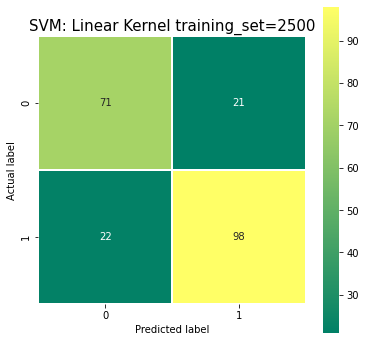

                 Open       High        Low      Close  Adj Close    Volume
Date                                                                       
2012-04-23  32.310001  32.500000  32.029999  32.119999  26.115328  61398200
2012-04-24  32.209999  32.520000  31.830000  31.920000  25.952721  40871100
2012-04-25  31.920000  32.320000  31.870001  32.200001  26.180370  62495500
2012-04-26  32.119999  32.230000  31.920000  32.110001  26.107203  40308100
2012-04-27  32.119999  32.220001  31.879999  31.980000  26.001499  41419100
(1855, 17) (1855,)
The accuracy of the set of labels for the dataset using SVM is 83.83620689655173 %


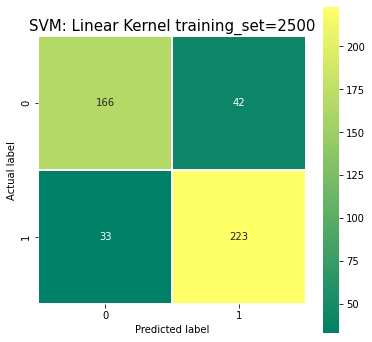

                 Open       High        Low      Close  Adj Close     Volume
Date                                                                        
2007-04-23  28.959999  28.990000  28.670000  28.780001  21.069555   41739100
2007-04-24  28.790001  28.959999  28.590000  28.790001  21.076881   34236700
2007-04-25  28.860001  29.000000  28.690001  28.990000  21.223295   39475000
2007-04-26  29.090000  29.350000  28.910000  29.100000  21.303827   68760300
2007-04-27  30.170000  30.740000  30.000000  30.120001  22.050556  128298800
(2864, 17) (2864,)
The accuracy of the set of labels for the dataset using SVM is 78.91061452513966 %


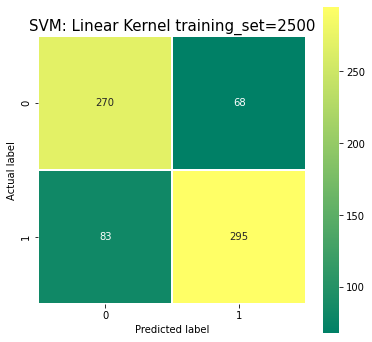

                 Open    High        Low      Close  Adj Close    Volume
Date                                                                    
2002-04-22  28.260000  28.350  27.500000  27.795000  17.511375  51465200
2002-04-23  27.850000  27.910  26.650000  26.995001  17.007366  68281400
2002-04-24  26.924999  27.215  26.500000  26.510000  16.701801  61220400
2002-04-25  26.450001  27.225  26.440001  26.865000  16.925459  57290400
2002-04-26  27.035000  27.225  25.730000  25.750000  16.222994  62776600
(3871, 17) (3871,)
The accuracy of the set of labels for the dataset using SVM is 82.64462809917356 %


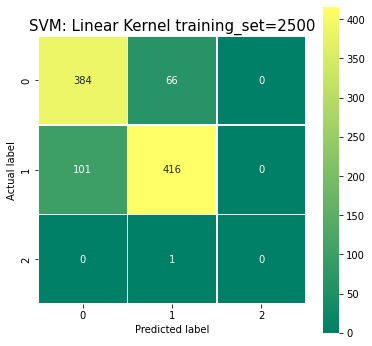

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
BP
                 Open       High        Low      Close  Adj Close   Volume
Date                                                                      
2017-04-24  34.389999  34.560001  34.320000  34.450001  25.469194  4980300
2017-04-25  34.549999  34.689999  34.490002  34.660000  25.624453  4428900
2017-04-26  34.570000  35.009998  34.529999  34.660000  25.624453  6208100
2017-04-27  34.520000  34.529999  34.099998  34.400002  25.432228  5884800
2017-04-28  34.340000  34.509998  34.259998  34.320000  25.373079  4257900
(849, 17) (849,)
The accuracy of the set of labels for the dataset using SVM is 68.39622641509435 %


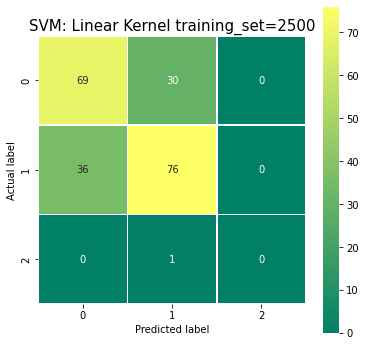

                 Open       High        Low      Close  Adj Close    Volume
Date                                                                       
2012-04-23  41.520000  42.040001  41.340000  41.950001  23.199158   5708100
2012-04-24  42.400002  42.450001  41.660000  41.910000  23.177048  10420400
2012-04-25  42.150002  42.220001  41.770000  42.189999  23.331888   6655500
2012-04-26  42.580002  43.349998  42.410000  43.290001  23.940208   6147000
2012-04-27  43.580002  43.639999  43.290001  43.529999  24.072931   3971100
(1855, 17) (1855,)
The accuracy of the set of labels for the dataset using SVM is 71.55172413793103 %


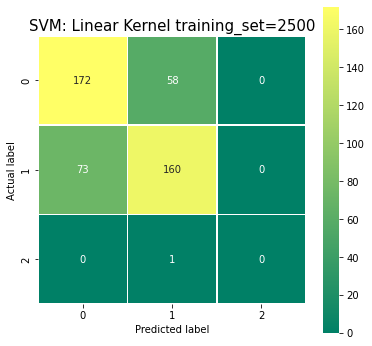

                 Open       High        Low      Close  Adj Close   Volume
Date                                                                      
2007-04-23  69.019997  69.750000  68.680000  68.739998  30.679817  3262800
2007-04-24  68.790001  68.820000  67.709999  67.760002  30.242428  4165800
2007-04-25  68.570000  69.050003  68.430000  69.000000  30.795874  4139600
2007-04-26  68.180000  68.389999  67.769997  68.019997  30.358475  3547600
2007-04-27  67.449997  67.940002  67.220001  67.720001  30.224583  2780800
(2864, 17) (2864,)
The accuracy of the set of labels for the dataset using SVM is 75.13966480446928 %


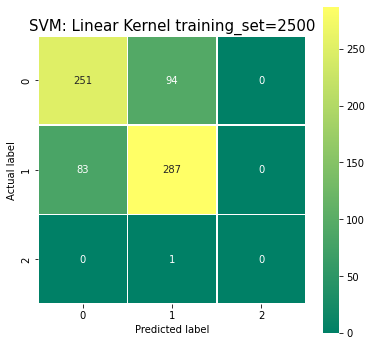

                 Open       High        Low      Close  Adj Close   Volume
Date                                                                      
2002-04-22  51.750000  52.009998  51.639999  51.720001  19.407537  1656600
2002-04-23  50.580002  51.570000  50.520000  51.250000  19.231180  1907800
2002-04-24  50.150002  50.299999  49.810001  49.860001  18.709591  2162000
2002-04-25  49.750000  50.200001  49.540001  49.900002  18.724604  2268000
2002-04-26  49.400002  49.520000  48.810001  49.500000  18.574507  2152500
(3871, 17) (3871,)
The accuracy of the set of labels for the dataset using SVM is 74.07024793388429 %


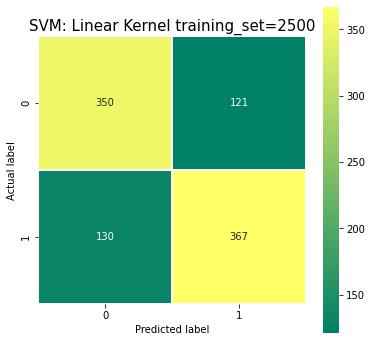

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
DIS
                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2017-04-24  115.260002  115.379997  113.660004  113.699997  108.881424   
2017-04-25  113.730003  115.519997  113.680000  115.180000  110.298698   
2017-04-26  115.400002  115.959999  114.860001  115.580002  110.681755   
2017-04-27  115.800003  116.099998  115.389999  115.839996  110.930725   
2017-04-28  115.870003  115.900002  115.239998  115.599998  110.700905   

             Volume  
Date                 
2017-04-24  7294600  
2017-04-25  6918300  
2017-04-26  4809800  
2017-04-27  3910800  
2017-04-28  3987600  
(849, 17) (849,)
The accuracy of the set of lab

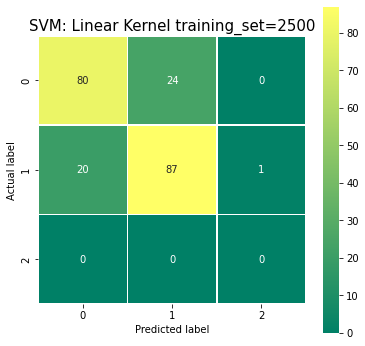

                 Open       High        Low      Close  Adj Close   Volume
Date                                                                      
2012-04-23  42.250000  42.250000  41.730000  42.009998  37.613388  6592100
2012-04-24  42.029999  42.430000  41.970001  42.180000  37.765594  4954600
2012-04-25  42.400002  42.759998  42.380001  42.700001  38.231174  4926300
2012-04-26  42.740002  43.560001  42.689999  43.360001  38.822109  7713000
2012-04-27  43.599998  43.650002  43.119999  43.349998  38.813152  6354200
(1855, 17) (1855,)
The accuracy of the set of labels for the dataset using SVM is 83.40517241379311 %


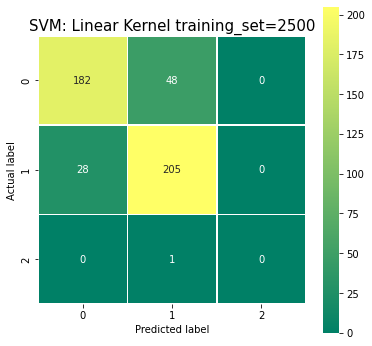

                 Open       High        Low      Close  Adj Close   Volume
Date                                                                      
2007-04-23  34.724800  34.823448  34.557095  34.606419  29.045719  6981551
2007-04-24  34.626148  34.764259  34.418983  34.438717  28.904966  6938976
2007-04-25  34.596554  34.951694  34.389389  34.843182  29.244442  9223923
2007-04-26  34.695206  34.991154  34.497906  34.695206  29.120235  7538976
2007-04-27  34.527500  34.655746  34.320335  34.507771  28.962925  6210340
(2864, 17) (2864,)
The accuracy of the set of labels for the dataset using SVM is 84.07821229050279 %


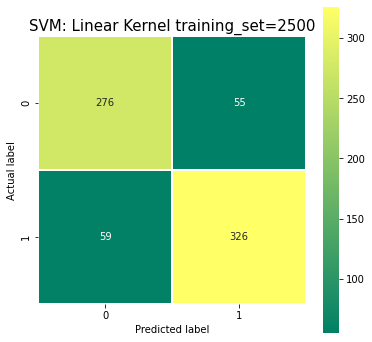

                 Open       High        Low      Close  Adj Close    Volume
Date                                                                       
2002-04-22  24.662500  24.800610  24.149521  24.208710  19.321093   5922960
2002-04-23  24.356686  24.761150  23.971951  24.169250  19.289595   5510086
2002-04-24  24.366550  24.662500  24.169250  24.188980  19.305351   6497010
2002-04-25  23.922625  24.810474  23.360319  24.662500  19.683268   9200710
2002-04-26  24.169250  24.534254  23.449104  23.774651  18.974672  11017233
(3871, 17) (3871,)
The accuracy of the set of labels for the dataset using SVM is 82.64462809917356 %


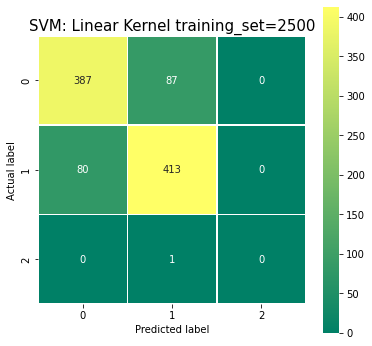

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
LMT
                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2017-04-24  275.540009  276.640015  274.309998  276.209991  242.171738   
2017-04-25  273.899994  274.500000  267.679993  270.019989  236.744537   
2017-04-26  270.589996  272.510010  269.540009  270.350006  237.033859   
2017-04-27  270.839996  272.769989  269.940002  271.140015  237.726517   
2017-04-28  271.070007  271.540009  268.619995  269.450012  236.244781   

             Volume  
Date                 
2017-04-24  1098800  
2017-04-25  2963900  
2017-04-26  1477200  
2017-04-27   953800  
2017-04-28  1004200  
(849, 17) (849,)
The accuracy of the set of lab

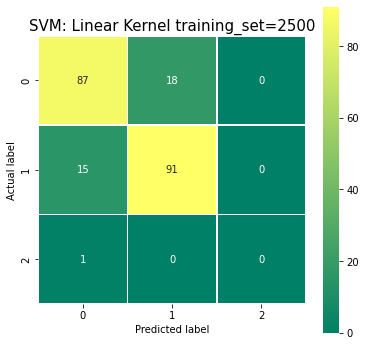

                 Open       High        Low      Close  Adj Close   Volume
Date                                                                      
2012-04-23  89.989998  90.739998  89.940002  90.529999  66.636124  1414300
2012-04-24  90.629997  91.290001  90.529999  91.129997  67.077789  1291400
2012-04-25  91.739998  91.889999  90.620003  90.980003  66.967354  1843400
2012-04-26  91.410004  92.239998  91.110001  91.699997  67.497314  1976200
2012-04-27  92.080002  92.089996  91.199997  91.300003  67.202904  1526500
(1855, 17) (1855,)
The accuracy of the set of labels for the dataset using SVM is 85.12931034482759 %


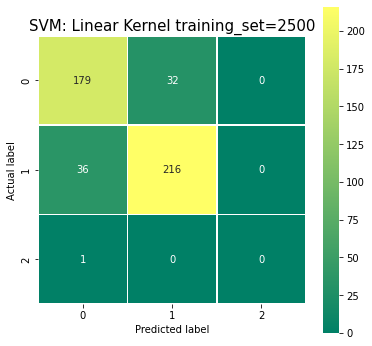

                 Open       High        Low      Close  Adj Close   Volume
Date                                                                      
2007-04-23  95.419998  97.879997  95.419998  97.070000  61.485653  2219600
2007-04-24  98.339996  98.339996  93.690002  94.820000  60.060436  4301300
2007-04-25  94.820000  95.849998  94.000000  95.500000  60.491177  3758100
2007-04-26  95.050003  95.250000  93.190002  93.500000  59.224327  3251200
2007-04-27  93.809998  96.900002  93.750000  96.690002  61.244949  2798700
(2864, 17) (2864,)
The accuracy of the set of labels for the dataset using SVM is 83.10055865921788 %


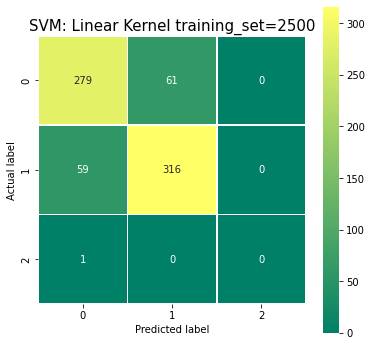

                 Open       High        Low      Close  Adj Close   Volume
Date                                                                      
2002-04-22  59.599998  59.880001  58.130001  59.119999  34.861603  3186200
2002-04-23  59.529999  62.250000  59.000000  62.200001  36.677799  4235600
2002-04-24  61.750000  62.200001  60.750000  61.119999  36.040936  3781200
2002-04-25  61.000000  62.919998  60.099998  62.779999  37.019810  3034600
2002-04-26  62.700001  63.049999  60.900002  61.520000  36.276817  2167300
(3871, 17) (3871,)
The accuracy of the set of labels for the dataset using SVM is 83.78099173553719 %


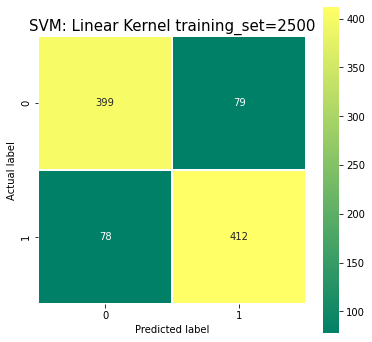

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
BTC-USD
                   Open         High          Low        Close    Adj Close  \
Date                                                                          
2017-04-22  1222.709961  1235.560059  1208.469971  1231.709961  1231.709961   
2017-04-23  1231.920044  1232.199951  1203.939941  1207.209961  1207.209961   
2017-04-24  1209.630005  1250.939941  1209.630005  1250.150024  1250.150024   
2017-04-25  1250.449951  1267.579956  1249.969971  1265.489990  1265.489990   
2017-04-26  1265.989990  1294.829956  1265.930054  1281.079956  1281.079956   

               Volume  
Date                   
2017-04-22  249320000  
2017-04-23  258951008  
2017-04-24  235806000  
2017-04-25  242556000  
2017-04-26  329631

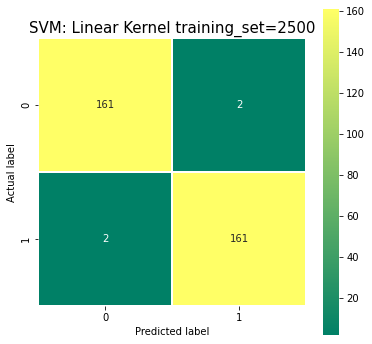

                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2014-09-17  465.864014  468.174011  452.421997  457.334015  457.334015   
2014-09-18  456.859985  456.859985  413.104004  424.440002  424.440002   
2014-09-19  424.102997  427.834991  384.532013  394.795990  394.795990   
2014-09-20  394.673004  423.295990  389.882996  408.903992  408.903992   
2014-09-21  408.084991  412.425995  393.181000  398.821014  398.821014   

              Volume  
Date                  
2014-09-17  21056800  
2014-09-18  34483200  
2014-09-19  37919700  
2014-09-20  36863600  
2014-09-21  26580100  
(2061, 17) (2061,)
The accuracy of the set of labels for the dataset using SVM is 97.66990291262137 %


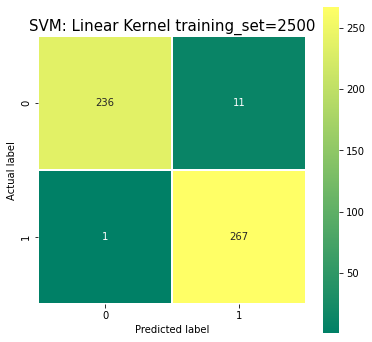

                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2014-09-17  465.864014  468.174011  452.421997  457.334015  457.334015   
2014-09-18  456.859985  456.859985  413.104004  424.440002  424.440002   
2014-09-19  424.102997  427.834991  384.532013  394.795990  394.795990   
2014-09-20  394.673004  423.295990  389.882996  408.903992  408.903992   
2014-09-21  408.084991  412.425995  393.181000  398.821014  398.821014   

              Volume  
Date                  
2014-09-17  21056800  
2014-09-18  34483200  
2014-09-19  37919700  
2014-09-20  36863600  
2014-09-21  26580100  
(2061, 17) (2061,)
The accuracy of the set of labels for the dataset using SVM is 97.86407766990291 %


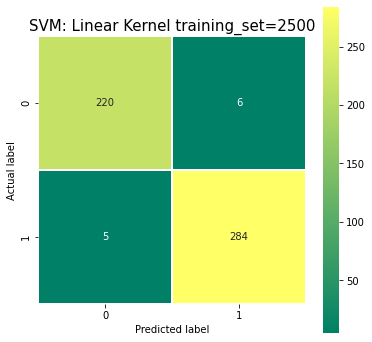

                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2014-09-17  465.864014  468.174011  452.421997  457.334015  457.334015   
2014-09-18  456.859985  456.859985  413.104004  424.440002  424.440002   
2014-09-19  424.102997  427.834991  384.532013  394.795990  394.795990   
2014-09-20  394.673004  423.295990  389.882996  408.903992  408.903992   
2014-09-21  408.084991  412.425995  393.181000  398.821014  398.821014   

              Volume  
Date                  
2014-09-17  21056800  
2014-09-18  34483200  
2014-09-19  37919700  
2014-09-20  36863600  
2014-09-21  26580100  
(2061, 17) (2061,)
The accuracy of the set of labels for the dataset using SVM is 96.89320388349515 %


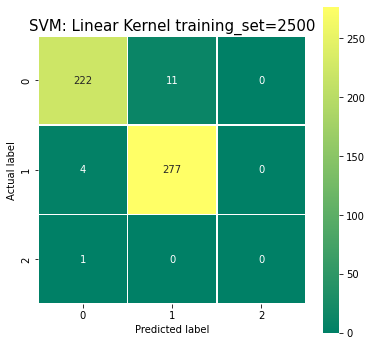

In [4]:
Tickers = ["MSFT","BP","DIS","LMT","BTC-USD"]
for tick in Tickers:
    stock5 = yf.download([tick],period = "5y")
    stock10 = yf.download([tick],period = "10y")
    stock15 = yf.download([tick],period = "15y")
    stock20 = yf.download([tick],period = "20y")
    print(tick)
    yearsused = 5
    years = [stock5,stock10,stock15,stock20]
    for stock in years:
        #print(stock.head())
        close_price = stock["Close"]
        volume = stock["Volume"]
        Open = stock["Open"]
        CHANGE = np.array([])

        MA50 = MA(close_price, 50)                                          # 50-day Moving Average
        EMA50 = EMA(close_price, MA50, 50)                                  # 50-day Exponential Moving Average
        MA200 = MA(close_price, 200)                                        # 200-day Moving Average
        EMA200 = EMA(close_price, MA200, 200)                               # 200-day Exponential Moving Average
        RSI14 = RSI(close_price, 14)                                        # RSI
        STOCH_K, STOCH_D = STOCH_RSI(close_price, 14, 14, 3)                # Stochastic RSI
        MACD_VALUE, SIG_LINE, MACD_HIST = MACD(close_price, 12, 26, 9)      # MACD
        BB_UP, BB_MID, BB_DOWN = BB(close_price, 20, 2)                     # Bollinger Bands
        #ADX14 = ADX(stock, 14)                                           # ADX

        stock["MA 50"] = MA50
        stock["EMA 50"] = EMA50
        stock["MA 200"] = MA200
        stock["EMA 200"] = EMA200
        stock["RSI 14"] = RSI14
        stock["STOCH K"] = STOCH_K
        stock["STOCH D"] = STOCH_D
        stock["MACD VALUE"] = MACD_VALUE
        stock["SIG LINE"] = SIG_LINE
        stock["MACD HIST"] = MACD_HIST
        stock["BB UP"] = BB_UP
        stock["BB MID"] = BB_MID
        stock["BB DOWN"] = BB_DOWN
        #stock["ADX"] = ADX14

        for i in range(0,len(Open)-1):    
            if Open[i]<Open[i+1]:
                CHANGE = np.append(CHANGE, 1)
            else:
                CHANGE = np.append(CHANGE, 0)    
        CHANGE = np.append(CHANGE, "NaN")
        stock["Change"] = CHANGE
        stock.dropna(axis=0, how='any', thresh=None, subset=None, inplace=True)
    
    
        features = ["Open","Low","High","Close","MA 50","EMA 50","MA 200","EMA 200",
           "RSI 14","STOCH K","STOCH D", "MACD VALUE", "SIG LINE", "MACD HIST",
           "BB UP","BB MID","BB DOWN"]


        ratio = round(0.8*stock.shape[0])
        X = stock[features]
        Y = stock["Change"]

        X_train, X_test, y_train, y_test = train_test_split(X,Y,train_size=ratio)
        #print(X_train.shape, y_train.shape)
        model=SVC(kernel="linear",C=100,random_state = 42069)
        svmfit = model.fit(X_train,y_train)

        y_preds = svmfit.predict(X_test)
        print('The accuracy of the model is: {:.2f}'.format(accuracy_score(y_test, y_preds)*100),"%")
    #     print('The recall score for the dataset using SVM is',(recall_score(y_test,y_preds,pos_label="1.0")*100),'%')
    #     print('The precision percent value for the dataset using SVM is',(precision_score(y_test,y_preds,pos_label="1.0")*100),'%')
        print('The f1 value for the model is: {:.2f}'.format(f1_score(y_test,y_preds,pos_label="1.0")*100),'%')
        
        cm_svm = metrics.confusion_matrix(y_preds,y_test)
        plt.figure(figsize=(6,6))
        sns.heatmap(cm_svm,annot=True,fmt="d",linewidths=.5,square=True,cmap="summer")
        plt.ylabel("Actual label")
        plt.xlabel("Predicted label")
        all_sample_title=(tick,"Stock confusion matrix")
        plt.title(all_sample_title,size=15)
        plt.show()
        yearsused = yearsused + 5

# Baseline model, LINE GO UP!

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
MSFT
The accuracy of the model is: 50.79 %
The f1 value for the model is: 67.37 %


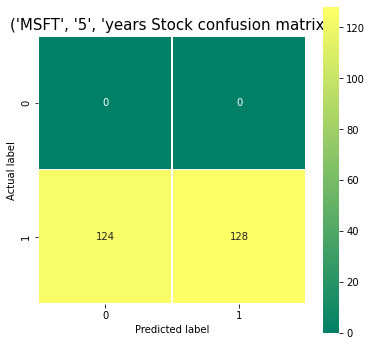

The accuracy of the model is: 54.47 %
The f1 value for the model is: 70.53 %


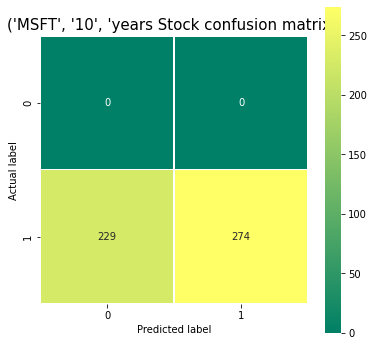

The accuracy of the model is: 52.91 %
The f1 value for the model is: 69.20 %


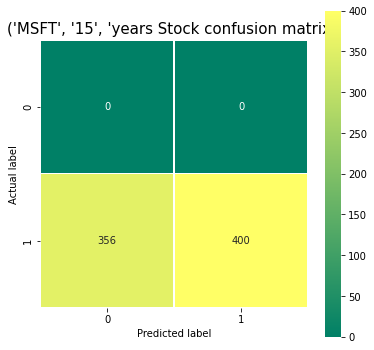

The accuracy of the model is: 49.45 %
The f1 value for the model is: 66.18 %


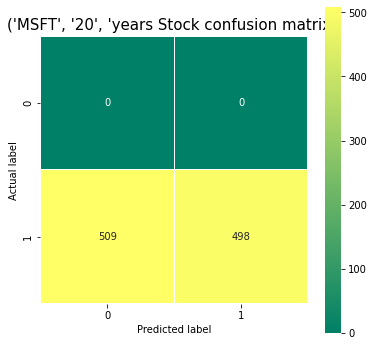

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
BP
The accuracy of the model is: 51.19 %
The f1 value for the model is: 67.72 %


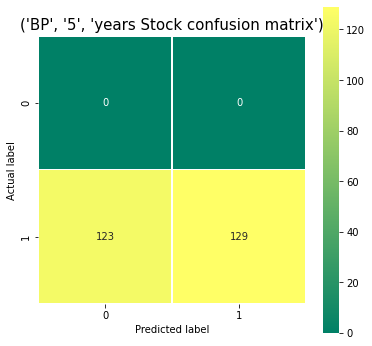

The accuracy of the model is: 50.89 %
The f1 value for the model is: 67.46 %


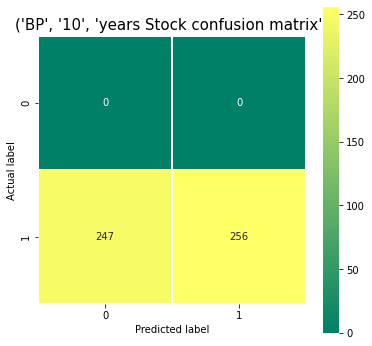

The accuracy of the model is: 53.44 %
The f1 value for the model is: 69.66 %


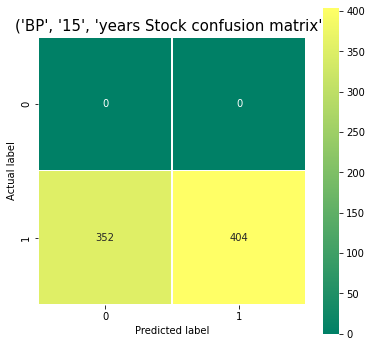

The accuracy of the model is: 49.35 %
The f1 value for the model is: 66.09 %


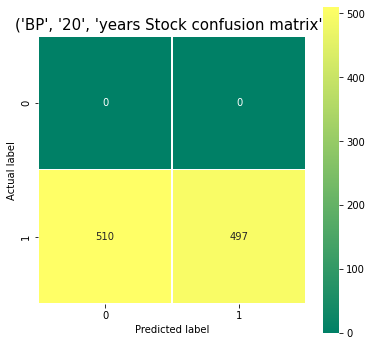

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
DIS
The accuracy of the model is: 50.40 %
The f1 value for the model is: 67.02 %


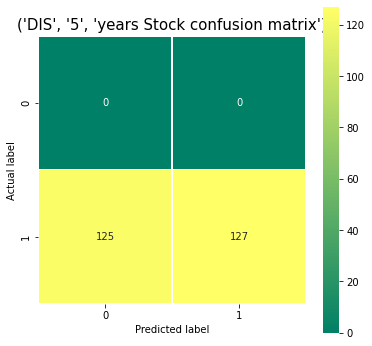

The accuracy of the model is: 53.68 %
The f1 value for the model is: 69.86 %


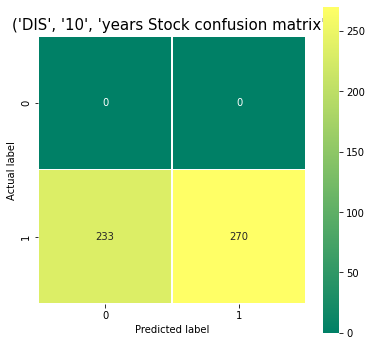

The accuracy of the model is: 48.54 %
The f1 value for the model is: 65.36 %


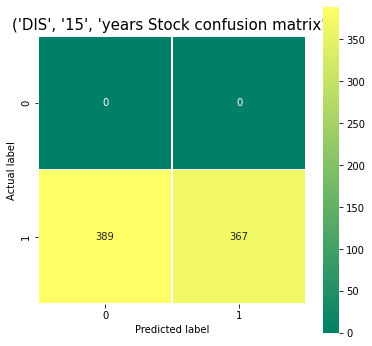

The accuracy of the model is: 50.74 %
The f1 value for the model is: 67.33 %


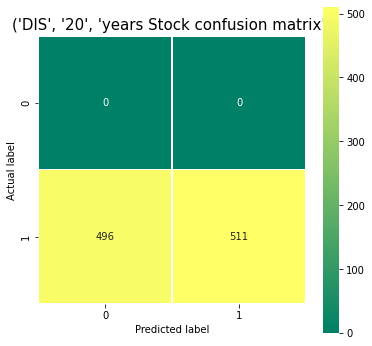

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
LMT
The accuracy of the model is: 57.54 %
The f1 value for the model is: 73.05 %


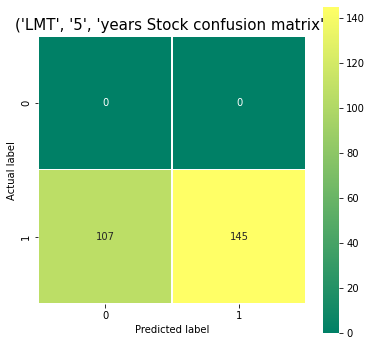

The accuracy of the model is: 54.27 %
The f1 value for the model is: 70.36 %


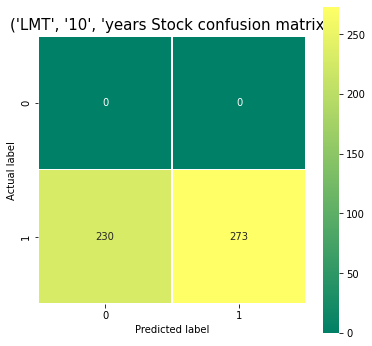

The accuracy of the model is: 52.51 %
The f1 value for the model is: 68.86 %


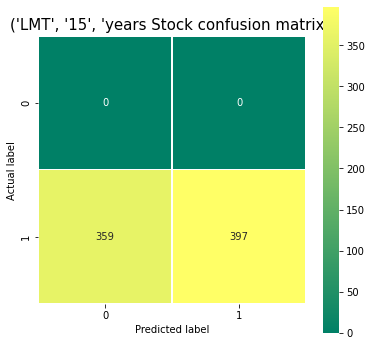

The accuracy of the model is: 52.53 %
The f1 value for the model is: 68.88 %


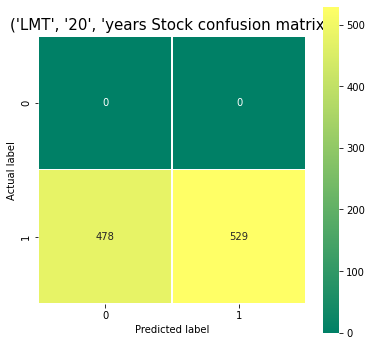

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
BTC-USD
The accuracy of the model is: 57.26 %
The f1 value for the model is: 72.82 %


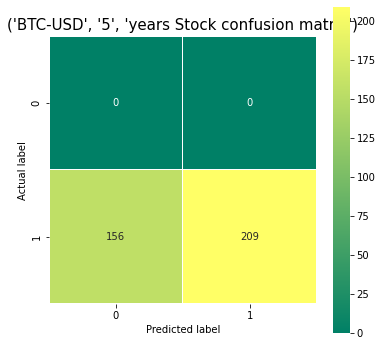

The accuracy of the model is: 54.95 %
The f1 value for the model is: 70.93 %


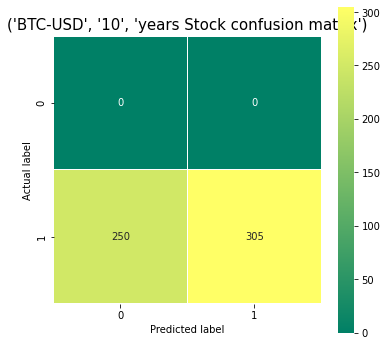

The accuracy of the model is: 57.30 %
The f1 value for the model is: 72.85 %


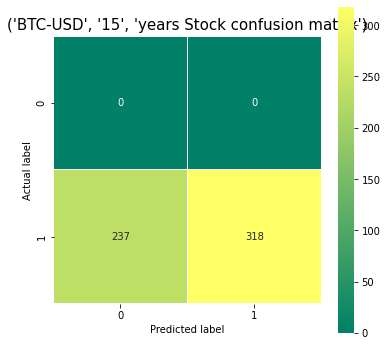

The accuracy of the model is: 52.79 %
The f1 value for the model is: 69.10 %


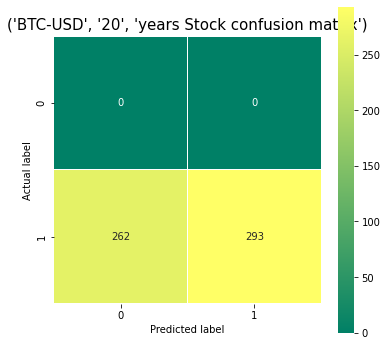

In [34]:
#5 different tickers: Microsoft, BP, Disney, Lockheed Martin, and bitcoin.
Tickers = ["MSFT","BP","DIS","LMT","BTC-USD"]
for tick in Tickers:
    stock5 = yf.download([tick],period = "5y")
    stock10 = yf.download([tick],period = "10y")
    stock15 = yf.download([tick],period = "15y")
    stock20 = yf.download([tick],period = "20y")
    years = [stock5,stock10,stock15,stock20]
    print(tick)
    yearsused = 5
    for stock in years:
       # print(stock.head())
        Open = stock["Open"]
        CHANGE = np.array([])

        for i in range(0,len(Open)-1):    
            if Open[i]<Open[i+1]:
                CHANGE = np.append(CHANGE, 1)
            else:
                CHANGE = np.append(CHANGE, 0)    
        CHANGE = np.append(CHANGE, "NaN")
        stock["Change"] = CHANGE
        stock = stock[:-1]
        
        features = ["Open","Low","High","Close"]

        ratio = round(0.8*stock.shape[0])
        X = stock[features]
        Y = stock["Change"]

        X_train, X_test, y_train, y_test = train_test_split(X,Y,train_size=ratio)
        #print(X_train.shape, y_train.shape)
        model=DummyClassifier(strategy = "constant", constant = "1.0",random_state = 42069)
        svmfit = model.fit(X_train,y_train)

        y_preds = svmfit.predict(X_test)
        print('The accuracy of the model is: {:.2f}'.format(accuracy_score(y_test, y_preds)*100),"%")
    #     print('The recall score for the dataset using SVM is',(recall_score(y_test,y_preds,pos_label="1.0")*100),'%')
    #     print('The precision percent value for the dataset using SVM is',(precision_score(y_test,y_preds,pos_label="1.0")*100),'%')
        print('The f1 value for the model is: {:.2f}'.format(f1_score(y_test,y_preds,pos_label="1.0")*100),'%')

        cm_svm = metrics.confusion_matrix(y_preds,y_test)
        plt.figure(figsize=(6,6))
        sns.heatmap(cm_svm,annot=True,fmt="d",linewidths=.5,square=True,cmap="summer")
        plt.ylabel("Actual label")
        plt.xlabel("Predicted label")
        all_sample_title=(tick, str(yearsused),"years Stock confusion matrix")
        plt.title(all_sample_title,size=15)
        plt.show()
        yearsused = yearsused + 5